In [1]:
import numpy as np
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
cmap = plt.get_cmap("viridis")

import config as u_config
from graph_models import FullGraphModel

from complete_training_data_processing import CompleteModelsDataProcessor
from manifold_funcs import manifold_test, extract_details
from manifold_plots import create_dash_app_two_sliders


device_type = "cpu" # "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_type)
dtype = torch.float32
batch_size = u_config.batch_size

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
data_processor = CompleteModelsDataProcessor(u_config)
model = FullGraphModel(data_processor, u_config).to(device)
criterion = CrossEntropyLoss()

checkpoint = torch.load(
    "models/m_2024-06-17 12:58_lrypvwbz.pth",
    map_location=device_type,
)
model.load_state_dict(checkpoint["model"])
torch.set_grad_enabled(False)
model.eval()

FullGraphModel(
  (connectome): Connectome()
  (final_fc): Linear(in_features=1, out_features=2, bias=True)
  (decision_making_dropout): Dropout(p=0, inplace=False)
)

In [3]:
test_results, final_plots, accuracy, intermediate, labels = manifold_test(
    model, data_processor, criterion, device, u_config
)

100%|██████████| 1875/1875 [16:05:37<00:00, 30.90s/it]  


Finished testing with loss 69830.69489361125 and accuracy 0.7701833333333333.


In [4]:
intermediate = intermediate.cpu().numpy()

test_results["radius"], test_results["distance"], test_results["angle"] = zip(
    *test_results["Image"].apply(extract_details)
)
test_results["shape"] = test_results["Image"].str.split("/").str.get(-2)
shape_colors = {"circle": "blue", "star": "red"}
test_results["colour"] = test_results["shape"].map(shape_colors)
bin_num = 30
test_results["distance"] = pd.cut(test_results["distance"], bins=bin_num, labels=False)
test_results["angle"] = pd.cut(test_results["angle"], bins=bin_num, labels=False)

In [5]:
from sklearn.manifold import TSNE

# Perform t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=3, random_state=42)
reduced_data = tsne.fit_transform(intermediate)
test_results["tsne_Component_1"] = reduced_data[:, 0]
test_results["tsne_Component_2"] = reduced_data[:, 1]
test_results["tsne_Component_3"] = reduced_data[:, 2]

In [ ]:
# test_results = pd.read_csv("results/manifolds.csv")

In [24]:
create_dash_app_two_sliders(test_results, "tsne")

In [25]:
import umap

# Perform UMAP to reduce to 2D for visualization
reducer = umap.UMAP(n_components=3)
reduced_data = reducer.fit_transform(intermediate)

test_results["umap_Component_1"] = reduced_data[:, 0]
test_results["umap_Component_2"] = reduced_data[:, 1]
test_results["umap_Component_3"] = reduced_data[:, 2]

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [27]:
create_dash_app_two_sliders(test_results, "umap")

In [28]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=3)
pca_2d_result = pca_2d.fit_transform(intermediate)

test_results["pca_Component_1"] = pca_2d_result[:, 0]
test_results["pca_Component_2"] = pca_2d_result[:, 1]
test_results["pca_Component_3"] = pca_2d_result[:, 2]

In [29]:
create_dash_app_two_sliders(test_results, "pca")

In [32]:
test_results.head()

,Image,Model outputs,Prediction,True label,Is correct,radius,distance,angle,shape,colour,tsne_Component_1,tsne_Component_2,tsne_Component_3,highlight,umap_Component_1,umap_Component_2,umap_Component_3,pca_Component_1,pca_Component_2,pca_Component_3
0,images/two_shapes_yellow/test/star/all_103_187...,"[0.49459067, 0.5054093]",1,1,1,103,22,18,star,red,7.695549,0.677105,37.095406,False,-6.555497,-0.889730,0.572664,-1.723182,-0.056328,-0.024633
1,images/two_shapes_yellow/test/circle/all_99_14...,"[0.8640309, 0.13596909]",0,0,1,99,17,1,circle,blue,16.549387,-23.785112,12.549836,False,-3.655586,9.042777,5.687041,16.449896,0.003587,0.069059
2,images/two_shapes_yellow/test/circle/all_107_1...,"[0.8094253, 0.19057468]",0,0,1,107,15,4,circle,blue,14.466310,-3.193221,-35.671059,False,10.435858,6.611917,4.009341,12.535399,0.047167,-0.045907
3,images/two_shapes_yellow/test/circle/all_104_1...,"[0.7358634, 0.2641366]",0,0,1,104,22,25,circle,blue,23.307123,23.635544,1.218487,False,8.678190,2.088831,2.363595,8.439159,0.022410,-0.048293
4,images/two_shapes_yellow/test/circle/all_82_80...,"[0.3116236, 0.6883764]",1,0,0,82,9,6,circle,blue,-20.067146,33.955383,-11.811337,False,3.897744,-8.646111,-2.640198,-9.214809,0.363663,0.003913


# 2D

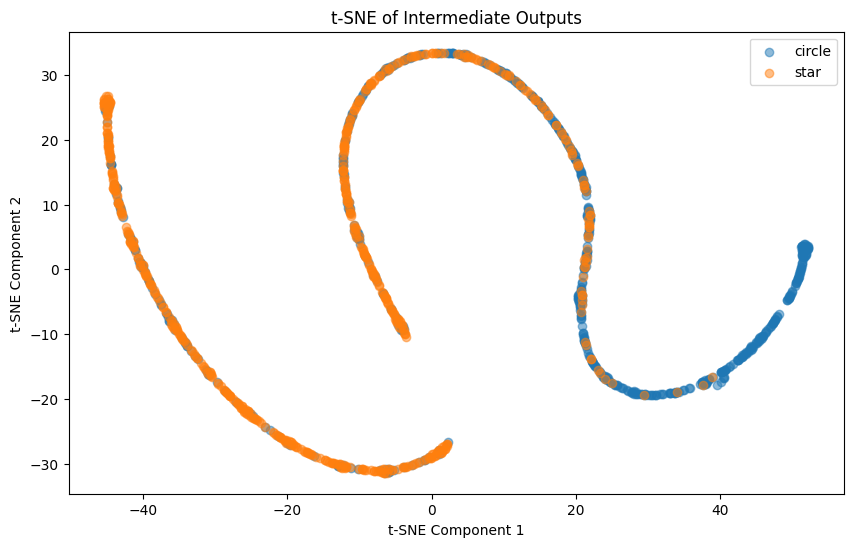

In [38]:
%matplotlib inline

from sklearn.manifold import TSNE

# Assuming `all_intermediate_outputs` is the tensor with shape (n, 916)
# and `labels` is a vector with the same length n, containing the labels (circle or star)

# Convert tensors to numpy arrays if they are not already
intermediate = intermediate.cpu().numpy()
# convert labels to numpy array
labels = np.array(labels).reshape(-1)
labels = np.array(["circle" if label == 0 else "star" for label in labels])

# Perform t-SNE to reduce to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(intermediate)

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(
        reduced_data[indices, 0], 
        reduced_data[indices, 1], 
        label=str(label),
        alpha=0.5
        )

plt.legend()
plt.title("t-SNE of Intermediate Outputs")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:373: UserWarning:

The number of connected components of the neighbors graph is 7 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/home/eudald/Desktop/doctorat/connectom

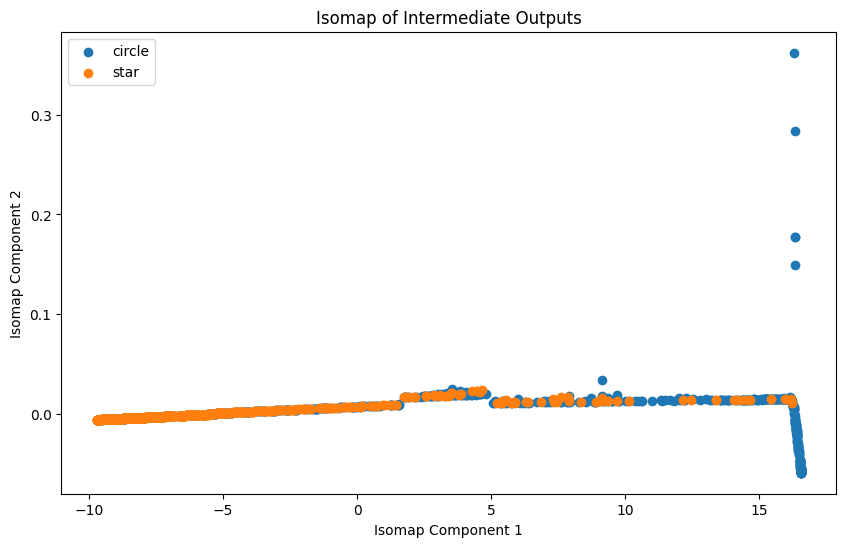

In [40]:
from sklearn.manifold import Isomap
np.random.seed(42)
# Perform Isomap to reduce to 2D for visualization
isomap = Isomap(n_components=2)
manifold_data = isomap.fit_transform(intermediate)

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(manifold_data[indices, 0], manifold_data[indices, 1], label=str(label))
plt.legend()
plt.title("Isomap of Intermediate Outputs")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.show()

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



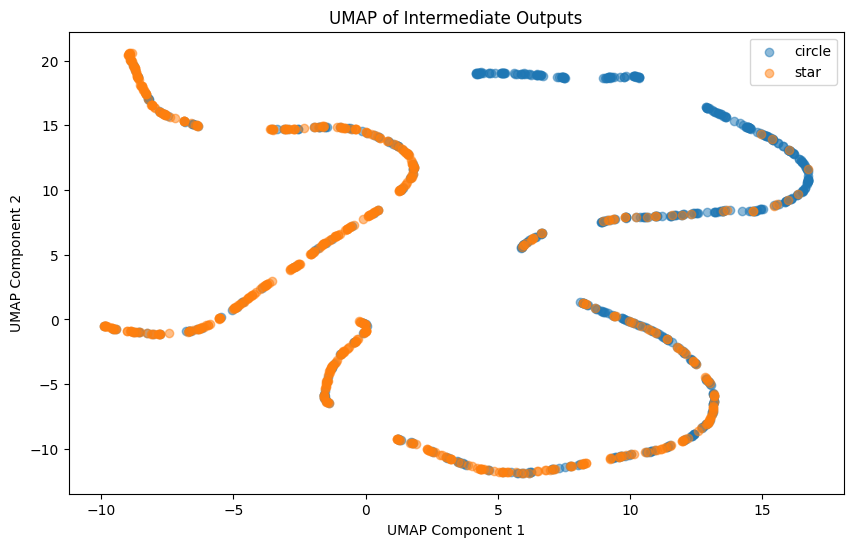

In [41]:
import umap

# Perform UMAP to reduce to 2D for visualization
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = reducer.fit_transform(intermediate)

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(
        reduced_data[indices, 0], 
        reduced_data[indices, 1], 
        label=str(label),
        alpha=0.5)

plt.legend()
plt.title("UMAP of Intermediate Outputs")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

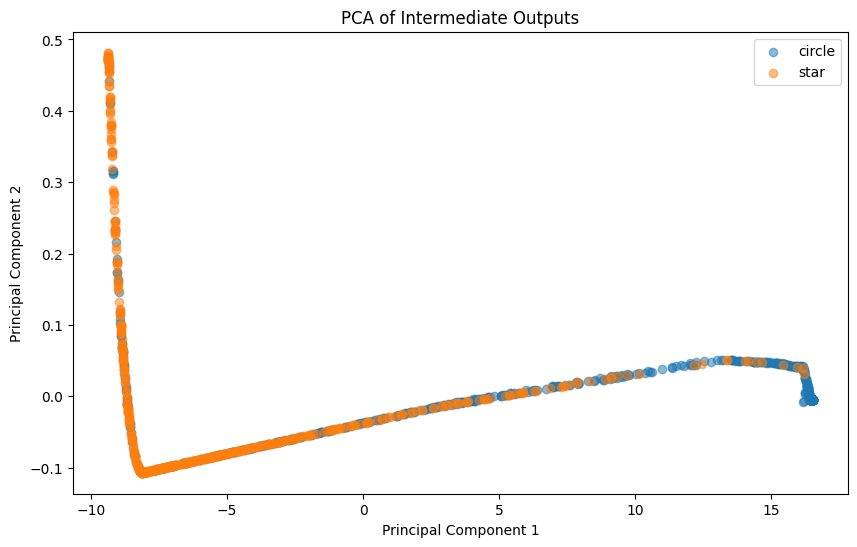

In [42]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
pca_2d_result = pca_2d.fit_transform(intermediate)

# Plotting
plt.figure(figsize=(10, 6))
for label in np.unique(labels):
    indices = labels == label
    plt.scatter(
        pca_2d_result[indices, 0],
        pca_2d_result[indices, 1],
        label=str(label),
        alpha=0.5,
    )

plt.legend()
plt.title("PCA of Intermediate Outputs")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [34]:
pca_2d_result

array([[ 1.2814436e+00, -2.7529333e-02],
       [ 1.6414764e+01,  2.3430819e-03],
       [ 1.3841656e+01,  4.9948573e-02],
       ...,
       [-6.8917694e+00, -9.7783387e-02],
       [ 1.6409325e+01,  3.6400091e-03],
       [-6.9647837e+00, -9.8339722e-02]], dtype=float32)

In [27]:
import plotly.express as px
import pandas as pd

# Perform t-SNE to reduce to 3D for visualization
tsne = TSNE(n_components=3, random_state=42)
tsne_3d = tsne.fit_transform(intermediate)

# Perform UMAP to reduce to 3D for visualization
reducer = umap.UMAP(n_components=3, random_state=42)
umap_3d = reducer.fit_transform(intermediate)

tsne_df = pd.DataFrame(tsne_3d, columns=["Component 1", "Component 2", "Component 3"])
tsne_df["Label"] = labels

umap_df = pd.DataFrame(umap_3d, columns=["Component 1", "Component 2", "Component 3"])
umap_df["Label"] = labels

# Plot t-SNE in 3D using plotly
fig_tsne = px.scatter_3d(
    tsne_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Label",
    title="t-SNE 3D of Intermediate Outputs",
)
fig_tsne.show()

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [28]:

# Plot UMAP in 3D using plotly
fig_umap = px.scatter_3d(
    umap_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Label",
    title="UMAP 3D of Intermediate Outputs",
)
fig_umap.show()

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [30]:
pca = PCA(n_components=3)
pca_3d = pca.fit_transform(intermediate)
pca_df = pd.DataFrame(pca_3d, columns=["Component 1", "Component 2", "Component 3"])
pca_df["Label"] = labels

fig_pca = px.scatter_3d(
    pca_df,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Label",
    title="PCA 3D of Intermediate Outputs",
)
fig_pca.show()

/home/eudald/Desktop/doctorat/connectome/venv/lib/python3.10/site-packages/plotly/express/_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

